# Fine-tuning BERT


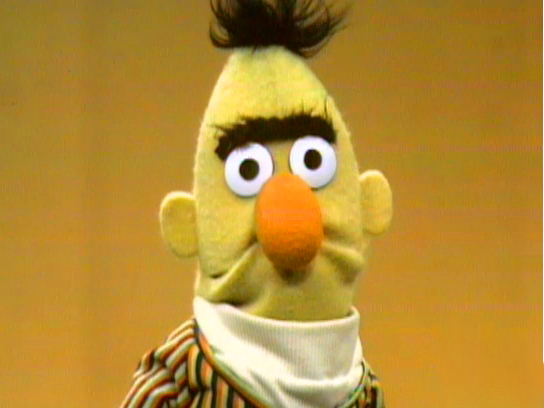

## Setup

In [1]:
!pip install gluonnlp

    100% |████████████████████████████████| 256kB 22.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for gluonnlp ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/af/60/16/1f8a40e68b85bd9bd7960e91830bca5e40cd113f3220b7e231
Successfully built gluonnlp
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import time
import multiprocessing as mp

import warnings
warnings.filterwarnings('ignore')

import io
import random
import numpy as np

import mxnet as mx
from mxnet import gluon
from mxnet.gluon import Block, nn



ctx = mx.gpu(0)
ctx = [mx.gpu(i) for i in range(8)]

In [2]:
import os
import boto3
import sagemaker
from sagemaker.mxnet import MXNet
from sagemaker import get_execution_role

sess = sagemaker.Session()

role = get_execution_role()
print(role)

arn:aws:iam::349934754982:role/SagemakerFullAccess


## Defining a model

### 1. Obtain dataset

In [4]:
import gluonnlp as nlp

train_dataset, test_dataset = [nlp.data.IMDB(root='data/imdb', segment=segment)
                               for segment in ('train', 'test')]

In [6]:
import numpy as np
train_dataset=np.asarray(train_dataset)
test_dataset=np.asarray(test_dataset)

In [7]:
os.makedirs("./datasets/train", exist_ok=True)
np.save("./datasets/train/train.npy", train_dataset)
os.makedirs("./datasets/test", exist_ok=True)
np.save("./datasets/test/test.npy", test_dataset)


## Fine-tuning the model

In [8]:
s3_bucket = sess.default_bucket()
s3_prefix = "news"

In [9]:
traindata_s3_prefix = f"{s3_prefix}/datasets/train"
testdata_s3_prefix = f"{s3_prefix}/datasets/test"
output_s3 = f"s3://{s3_bucket}/{s3_prefix}/models/"

In [10]:
train_s3 = sess.upload_data(path="./datasets/train/", bucket=s3_bucket, key_prefix=traindata_s3_prefix)
test_s3 = sess.upload_data(path="./datasets/test/", bucket=s3_bucket, key_prefix=testdata_s3_prefix)

In [11]:
inputs = { "train": train_s3, "test": test_s3 }
print(inputs)

{'train': 's3://sagemaker-us-east-1-349934754982/news/datasets/train', 'test': 's3://sagemaker-us-east-1-349934754982/news/datasets/test'}


Now we have all the pieces to put together, and we can finally start fine-tuning the
model with very few epochs. For demonstration, we use a fixed learning rate and
skip the validation steps. For the optimizer, we leverage the ADAM optimizer which
performs very well for NLP data and for BERT models in particular.

### Define hyperparameters

In [12]:

hyperparameters = { "network": 'bert_24_1024_16',"lr": 5e-6, "epochs": 1, "batch-size": 8,"batch-size-test": 8, "grad-clip": 1 ,"num-classes": 2,"log-interval": 100 }


In [14]:
import mxnet as mx
mx.__version__

'1.6.0'

### Define training function

### Train the model

In [16]:
estimator = MXNet(
    entry_point="bert_train.py",
    source_dir="./src",
    train_instance_count=1,
    train_instance_type="ml.p3.8xlarge",
    role=role,
    framework_version="1.6.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    base_job_name="bert-mxnet",
)

estimator.fit(inputs)

2020-04-04 19:15:41 Starting - Starting the training job...
2020-04-04 19:15:43 Starting - Launching requested ML instances.........
2020-04-04 19:17:13 Starting - Preparing the instances for training......
2020-04-04 19:18:19 Downloading - Downloading input data......
2020-04-04 19:19:35 Training - Training image download completed. Training in progress..2020-04-04 19:19:36,169 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2020-04-04 19:19:36,216 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch-size":8,"batch-size-test":8,"epochs":1,"grad-clip":1,"log-interval":100,"lr":5e-06,"network":"bert_24_1024_16","num-classes":2}', 'SM_USER_ENTRY_POINT': 'bert_train3.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"test":{"RecordWrapperType"

## Predict using model

In [18]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')

-------------!

In [22]:
data = "this movie was terrible"

response = predictor.predict(data)
print(response)

{'score': [0.999717652797699, 0.00028229522285982966]}
